In [1]:
'''
Basic implementation of Q Learning without neural networks
Sometimes the machine will get stuck in an infinite loop of non-scoring moves. If so just rerun the script
'''
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

#%%

In [2]:
from snake import SnakeGame

In [3]:
def evaluateScore(Q, boardDim, numRuns, displayGame=False):
    # Run the game for a specified number of runs given a specific Q matrix
    cutoff = 100  # X moves without increasing score will cut off this game run
    scores = []
    for i in range(numRuns):
        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        score = 0
        oldScore = 0
        gameOver = False
        moveCounter = 0
        while not gameOver:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
            state, reward, gameOver, score = game.makeMove(action)
            if score == oldScore:
                moveCounter += 1
            else:
                oldScore = score
                moveCounter = 0
            if moveCounter >= cutoff:
                # stuck going back and forth
                break
        scores.append(score)
    return np.average(scores), scores

## Hyperparameters

In [4]:
boardDim = 16  # size of the baord

# state is as follows.
# Is direction blocked by wall or snake?
# Is food in this direction? can either be one or two directions eg (food is left) or (food is left and up)
# state =  (top blocked, right blocked, down blocked, left blocked, up food, right food, down food, left food)
# 8 boolean values. Not all states are reachable (eg states with food directions that don't make sense)
numStates = 2**8
numActions = 4  # 4 directions that the snake can move
Q = np.zeros((numStates, numActions))

# lr = 0.9 #learning rate. not used in this Q learning equation
gamma = 0.8  # discount rate
epsilon = 0.2  # exploration rate in training games
numEpisodes = 10001  # number of games to train for

In [5]:
Qs = np.zeros([numEpisodes, numStates, numActions])
bestLength = 0
print("Training for", numEpisodes, "games...")
for episode in range(numEpisodes):
    #    print("New Game")
    game = SnakeGame(boardDim, boardDim)
    state = game.calcStateNum()
    gameOver = False
    score = 0
    while not gameOver:
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 3)
        else:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
        new_state, reward, gameOver, score = game.makeMove(action)

        # http: // mnemstudio.org/path-finding-q-learning-tutorial.htm
        Q[state, action] = reward + gamma * np.max(Q[new_state, :])

        # https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
        # Q[state, action] = Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
        state = new_state
    Qs[episode, :, :] = np.copy(Q)
    if episode % 100 == 0:
        averageLength, lengths = evaluateScore(Q, boardDim, 25)
        if averageLength > bestLength:
            bestLength = averageLength
            bestQ = np.copy(Q)
        print("Episode", episode, "Average snake length:", averageLength)

Training for 10001 games...
Episode 0 Average snake length: 1.04
Episode 100 Average snake length: 3.56
Episode 200 Average snake length: 5.88
Episode 300 Average snake length: 7.4
Episode 400 Average snake length: 11.4
Episode 500 Average snake length: 4.36
Episode 600 Average snake length: 13.64
Episode 700 Average snake length: 15.24
Episode 800 Average snake length: 16.2
Episode 900 Average snake length: 14.28
Episode 1000 Average snake length: 10.28
Episode 1100 Average snake length: 13.88
Episode 1200 Average snake length: 19.08
Episode 1300 Average snake length: 21.88
Episode 1400 Average snake length: 18.52
Episode 1500 Average snake length: 23.76
Episode 1600 Average snake length: 22.56
Episode 1700 Average snake length: 25.4
Episode 1800 Average snake length: 19.12
Episode 1900 Average snake length: 24.6
Episode 2000 Average snake length: 26.76
Episode 2100 Average snake length: 20.8
Episode 2200 Average snake length: 24.2
Episode 2300 Average snake length: 25.0
Episode 2400 

Generating data for animation...
Game 0 finished, total moves: 209
Game 1 finished, total moves: 571
Game 2 finished, total moves: 901
Game 3 finished, total moves: 1300
Game 4 finished, total moves: 1735
Animating snakes at different episodes...
1735


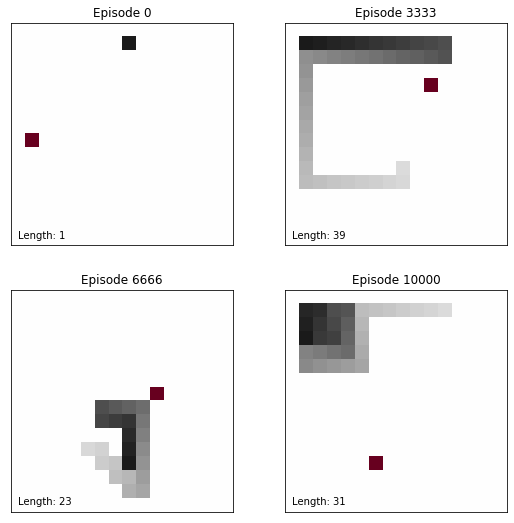

In [6]:
#%%
#Animate games at different episodes
print("Generating data for animation...")
plotEpisodes = np.asarray(np.linspace(0,numEpisodes-1,4),dtype="int")
fig, axes = plt.subplots(2, 2, figsize=(9,9))

axList = []
ims = []
dataArrays = []
scores = []
labels = []

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title("Episode " + str(plotEpisodes[i*len(row) + j]))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        axList.append(ax)
        ims.append(ax.imshow(np.zeros([boardDim, boardDim]), vmin=-1, vmax=1, cmap='RdGy'))
        labels.append(ax.text(0,15, "Length: 0", bbox={'facecolor':'w', 'alpha':0.75, 'pad':1, 'edgecolor':'white'}))
        dataArrays.append(list())
        scores.append(list())
        
stopAnimation = False
maxFrames = 1000
cutoff = 100
numGames = 5 #set to 1 if wait too long
for k in range(numGames):
    games = []
    states = []
    gameOvers = []
    moveCounters = []
    oldScores = []
    for l in range(len(plotEpisodes)):
        game = SnakeGame(boardDim, boardDim)
        games.append(game)
        states.append(game.calcStateNum())
        gameOvers.append(False)
        moveCounters.append(0)
        oldScores.append(0)
    for j in range(maxFrames):
        for i in range(len(plotEpisodes)):
            possibleQs = Qs[plotEpisodes[i], :, :][states[i], :]
            action = np.argmax(possibleQs)
            states[i], reward, gameOver, score = games[i].makeMove(action)
            if gameOver:
                gameOvers[i] = True
            dataArrays[i].append(games[i].plottableBoard())
            scores[i].append(score)
            if score == oldScores[i]:
                moveCounters[i] += 1
            else:
                oldScores[i] = score
                moveCounters[i] = 0
            if moveCounters[i] >= cutoff:
                # stuck going back and forth
                gameOvers[i] = True
        if not any(gameOver == False for gameOver in gameOvers):
            print("Game", k, "finished, total moves:", len(dataArrays[0]))
            break

def animate(frameNum):
    for i, im in enumerate(ims):
        labels[i].set_text("Length: " + str(scores[i][frameNum]))
        ims[i].set_data(dataArrays[i][frameNum])
    return ims+labels
print("Animating snakes at different episodes...")

numFrames = len(dataArrays[0])
print(numFrames)
ani = animation.FuncAnimation(fig, func=animate, frames=numFrames,blit=True, interval=75, repeat=False )
rc('animation', html='html5')
ani
#%%

In [7]:
##uncomment below if you want to output to a video file
print("Saving to file")
ani.save('snake_Qlearning.mp4', fps=15, extra_args=['-vcodec', 'libx264'])
print("Done")

Saving to file
Done
